# Spherical Multipole Form
<center> Here we will construct spherical multipoles using MMRDNS, and then compare to NR data. </center>

#### Preliminaries:


 A. $h = \sum_{j} h_{j} Y_{j}$, where $j\leftrightarrow (l,m)$, with $h_j = \int_{\Omega} h\bar{Y}_{j} d\Omega$. This is the spherical multipole representation. It is a true spectral representation.
 
 B. $h = \sum_{k} h_{k} S_{k}$, where $k\leftrightarrow (\ell,m,n,)$. This is the spheroidal multipole representation. It is not spectral because $S_{k}$ is not orthogonal with $S_{k'\neq k}$ on the unit sphere. 
 
 C. AB $ \rightarrow \; h_{j} = \sum_{k} h_{k} \left( \int_{\Omega} S_{k}\bar{Y}_{j} d\Omega \right) $ -- These are the spherical multipoles of NR. They are sums of the inner-products calculated in issue 2 multiplied by the spheroidal modes. Here we wish to calculate these $h_{j}$ for MMRDNS.

#### Notes:
 * For this to work the folloing have been implemented:
  * Fits for spherical-spheroidal inner products
  * Functions to generate the time domain waveform: ```XLALSimRingdownGenerateSphericalMultipoleMMRDNS_time``` and ```XLALSimRingdownAddSpheroidalModeTD```
  * LAL function to conpute total waveform using the Spherical rather than spheroidal basis.

## Setup Environment

In [2]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm,ysprod,ssprod
from kerr.models import mmrdns
from kerr.models import mmrdnp
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
plotdir = '/Users/book/KOALA/review_ringdownFD_nikhef/gallery/'

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Select and Load NR Data

Note that here we apply the RIT remnant fits to the simulation metadata as BAM runs do not have reliable final mass and spin values from their post-processing.

In [13]:
# Find simlations to load 
# A = scsearch(keyword='q10c25e_T_112_448',verbose=True,nonspinning=True, apply_remnant_fit=True)
# A = scsearch(keyword='D11_q1.00_a0.0_m240',verbose=True)
# A = scsearch(keyword='q18a0a0c025_144',verbose=True, apply_remnant_fit=True )
# A = scsearch(keyword='q4a0_T_112_448',verbose=True, apply_remnant_fit=True)
# A = scsearch(institute='bam',nonspinning=True,verbose=True, apply_remnant_fit=True)
A = scsearch(q=4,keyword='hrq',nonspinning=True,verbose=True)

(scsearch)>> Found keyword (='hrq') keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=4) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch)>> List of keywords or string keyword found: ALL scentry objects matching will be passed. To pass ANY entries matching the keywords, input the keywords using an iterable of not of type list.
## Found 1 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q4.00	(D9_q4.0_a0.0_m160)



## Load simulation data

In [14]:
# Load simulation data
a = A[0]
# y = gwylm( a, lm=[(2,2)], verbose=True )
lmlist = []
for lm in [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5)]:
    l,m = lm; 
    lmlist+=[(l,m)]; lmlist+=[(l,-m)]
y = gwylm( a, lm=lmlist, verbose=True, clean=True )
# y = gwylm( a, lmax=5, verbose=True )

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.15) keyword.
(gwylm)>> Found lm (=[(2, 2), (2, -2), (2, 1), (2, -1), (3, 3), (3, -3), (3, 2), (3, -2), (4, 4), (4, -4), (4, 3), (4, -3), (5, 5), (5, -5)]) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x121e79680>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Volumes/athena/bradwr/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist__)>> The following spherical multipoles will be loaded:[(2, 2), (2, -2), (2, 1), (2, -1), (3, 3), (3, -3), (3, 2), (3, -2), (4, 4), (4, -4), (4, 3), (4, -3), (5, 5), (5, -5)]
(load)>

## Extract Ringdown

In [23]:
# Extract Ringdown
yrd = y.ringdown(T0=10,T1=200,use_peak_strain=False,verbose=True)

(ringdown)>> Time will be listed relative to the peak of luminosity.


## Define Constants for Physical Units

In [24]:
# Define physical parameters for LAL comparison
M_Sol = 100
Mf_Sol = M_Sol * y.mf
D_Mpc = 150
# Not all of these are used here.
inclination = pi/4
fmin = 20
phi_ref = pi/3
#
M = M_Sol*MSUN_SI
Mf = Mf_Sol*MSUN_SI
D = D_Mpc*1.0e6*PC_SI
#
t_code = yrd.lm[2,2]['strain'].t
deltaT = physt( diff(t_code)[0], M_Sol )
t = physt(t_code,M_Sol)
xf = y.xf
eta = y.eta

## Compare NR to MMRDNS-LAL for a single Spherical Multipole

Note that at this point there is no aligment of orbital phase and system polarization. So there will be phase differences. In the next section we apply a cross-correlation based alignemnt algorithm.

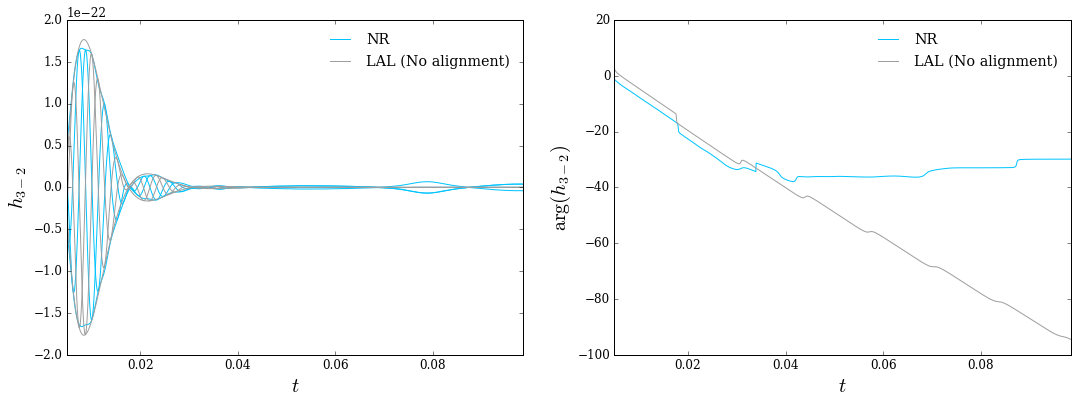

In [25]:
ll,mm = 3,-2

hlalraw = lalsim.SimRingdownGenerateSphericalMultipoleMMRDNS_time( 0, deltaT, Mf, xf, eta, ll, mm, D, None, len(t_code), 0  )
hlal = hlalraw.data.data

hnrraw = physh( yrd.lm[ll,mm]['strain'].wfarr, M_Sol, D_Mpc )
hnr = hnrraw[:,1] + hnrraw[:,2]*1j

#
def plotc(t, c,color='k',alpha=1,label=None,linestyle='-',lw=2):
    #
    subplot(1,2,1)
    plot( t, c.real, color = color, alpha=alpha, label=label,linestyle=linestyle,linewidth=lw )
    plot( t, c.imag, color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    plot( t, abs(c), color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    plot( t,-abs(c), color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    xlim( lim(t) )
    legend( frameon=False )
    #
    ylabel(r'$h_{%i%i}$'%(ll,mm)); xlabel('$t$')
    #
    subplot(1,2,2)
    plot( t, unwrap(angle(c)), color = color, alpha=alpha, label=label,linestyle=linestyle,linewidth=lw )
    xlim( lim(t) )
    legend( frameon=False )
    #
    ylabel(r'$\mathrm{arg}( h_{%i%i} )$'%(ll,mm)); xlabel('$t$')

#
fig = figure( figsize = 6*array([3,1]) )
clr = rgb(3)
#
plotc( t, hnr, color=clr[0], label = 'NR',linestyle='-', lw=1 )
plotc( t, hlal, color=clr[1], label = 'LAL (No alignment)',linestyle='-',lw=1 )

## Evaluate LAL model as gwylm class object

In [26]:

def gwylm_meval(eta,lmlist=None):

    #
    from nrutils import scentry,gwylm,gwf
    from numpy import inf,zeros
    #
    import lal
    from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
    import lalsimulation as lalsim

    #
    e = scentry( None, None )
    m1,m2 = mmrdnp.eta2m1m2(eta)
    e.m1,e.m2 = M*m1,M*m2
    chi1,chi2 = zeros(3),zeros(3)
    e.S1,e.S2 = chi1,chi2

    #
    e.xf,e.mf = mmrdnp.Mfjf(m1,m2,chi1[-1],chi2[-1])
    e.mf *= M
    e.default_extraction_par = inf
    e.default_level = None
    e.config = None
    e.setname = 'LAL'
    e.label = 'MMRDNS'

    _ = [(2,2),(2,1),(3,3),(4,4),(3,2),(4,3),(5,5)]
    _lmlist = []
    for k in _: 
        _lmlist += [ (k[0], k[-1]) ]
        _lmlist += [ (k[0],-k[-1]) ]
    lmlist = _lmlist if lmlist is None else lmlist

    #
    y = gwylm(e,load=False)
    y.__lmlist__ = lmlist
    y.__input_lmlist__ = lmlist

    #
    for ll,mm in lmlist:
        hlalraw = lalsim.SimRingdownGenerateSphericalMultipoleMMRDNS_time( 0, deltaT, Mf, xf, eta, ll, mm, D, None, len(t_code), 0  )
        hlal = hlalraw.data.data
        wfarr = array([ t, hlal.real, hlal.imag ]).T
        y.hlm.append(  gwf( wfarr,l=ll,m=mm,kind='$rh_{%i%i}/M$'%(ll,mm) )  )

    #
    y.__curate__()

    #
    return y

In [27]:
a = gwylm_meval(eta,lmlist=None)

In [28]:
# a.plot(kind='strain')

## Convert the NR ringdown to physical units, and the align with the LAL model

#### Notes:
 * Quality issues with NR waveforms are visible
 * Some systematic differeces between NR and model are suggested by early time behavior of waveforms outside of MAYA calibration set
 * Overtones have the effect of modeling the early time region where instanteneous frequency is varing significantly


(align)>> Performing sky-averaged match (no noise curve) to estimate optimal shift in orbital phase.
(align)>> Obtaining numerical estimate of optimal shift in orbital phase.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(align)>> (dphi_opt,dpsi_opt) = (-0.0478,-2.9354)


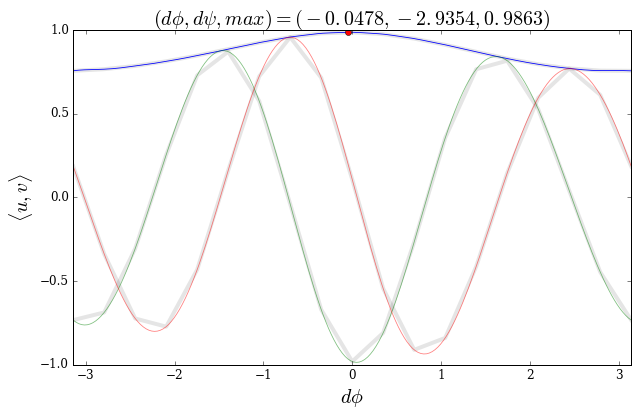

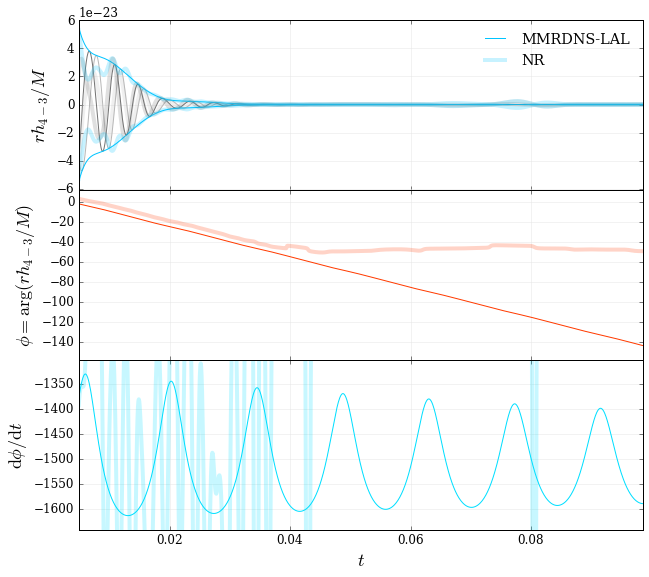

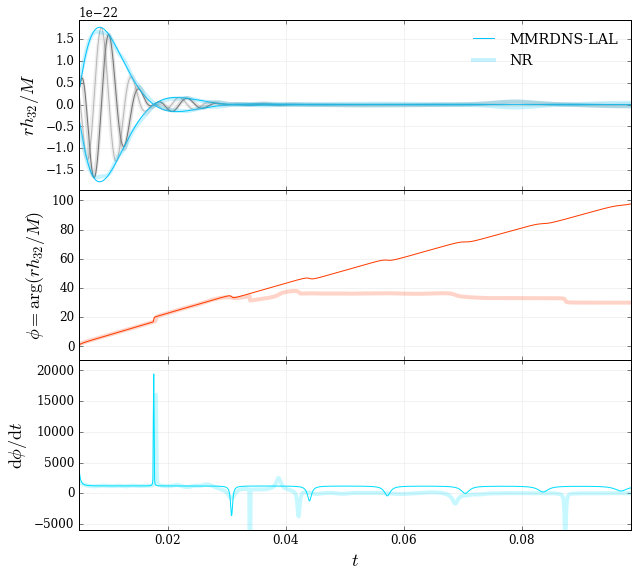

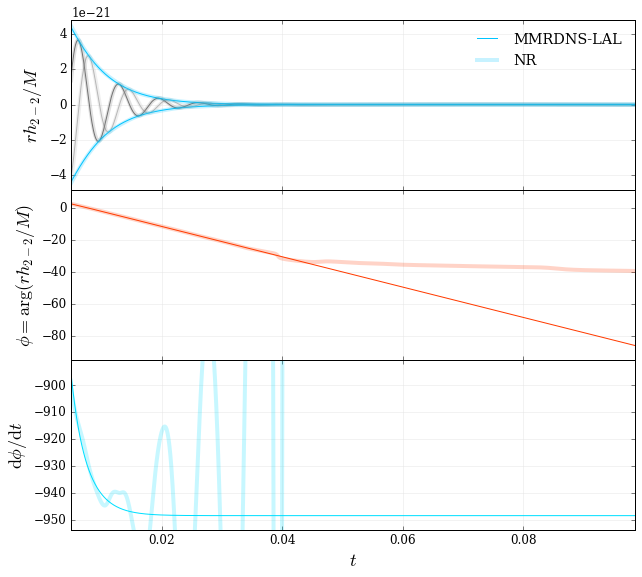

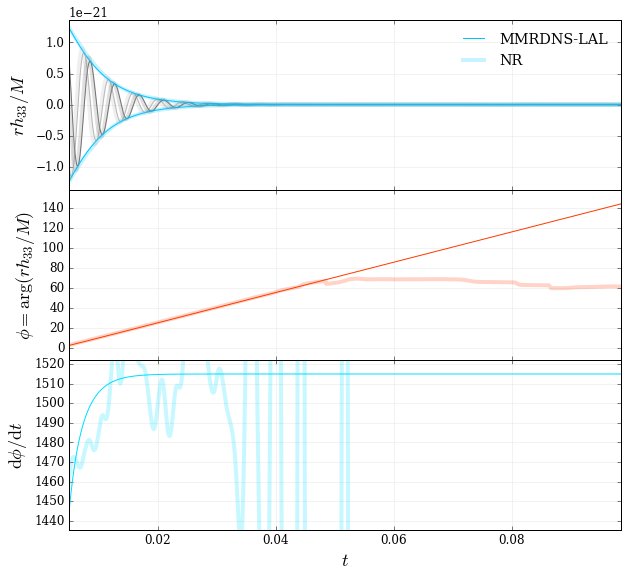

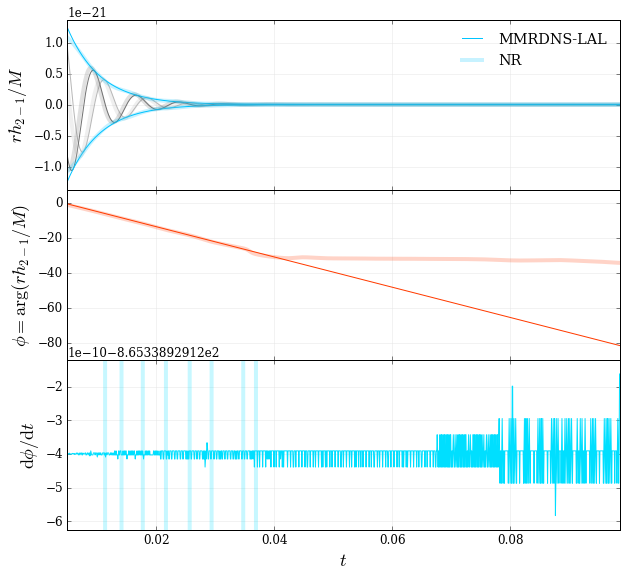

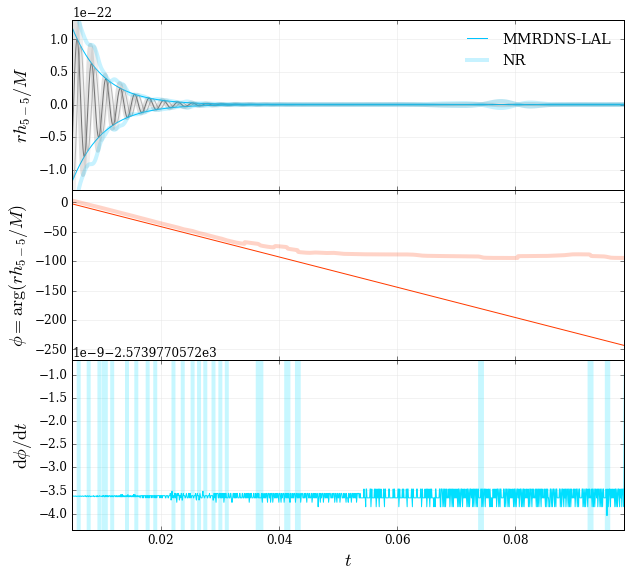

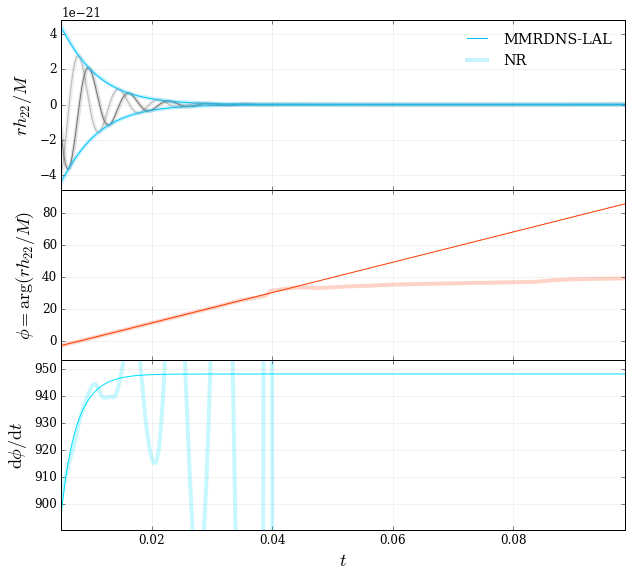

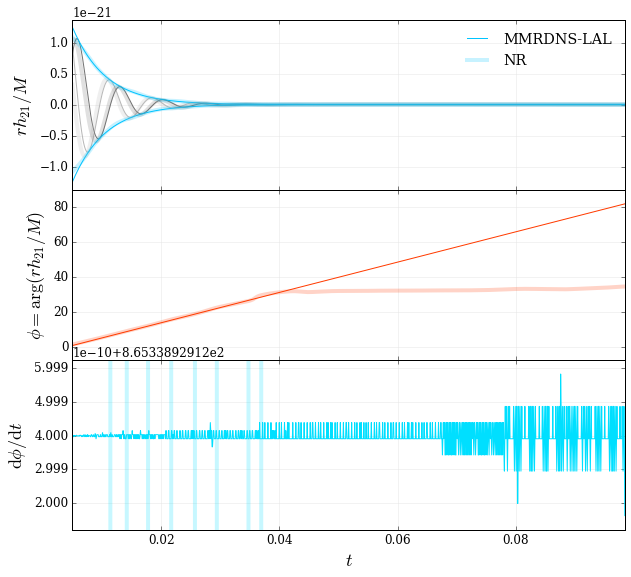

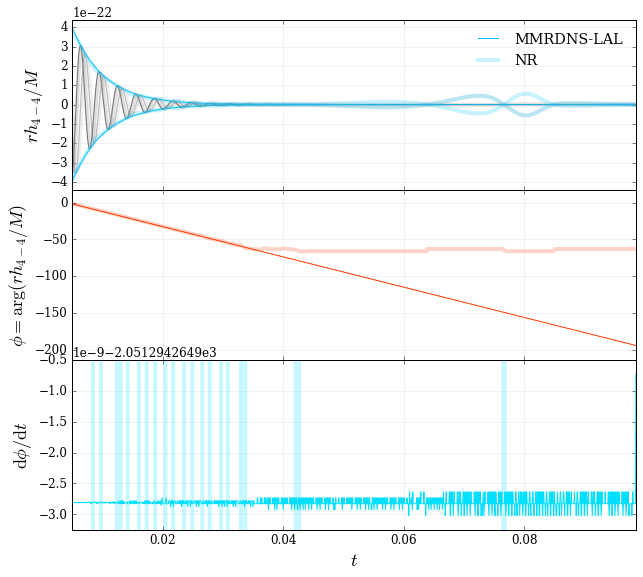

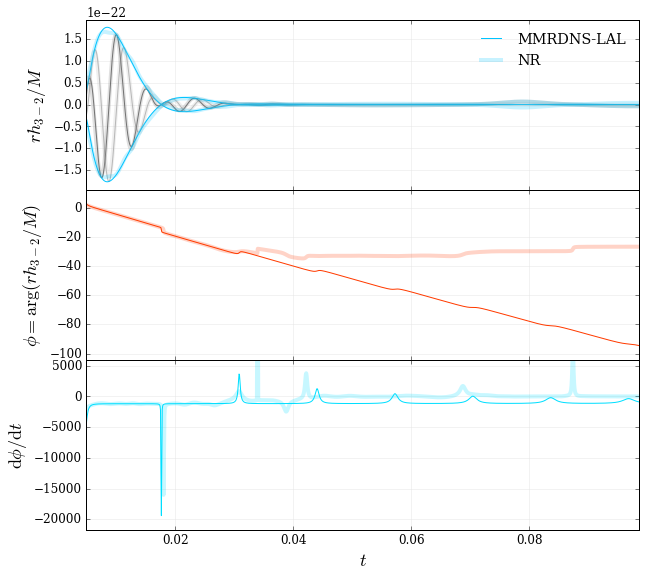

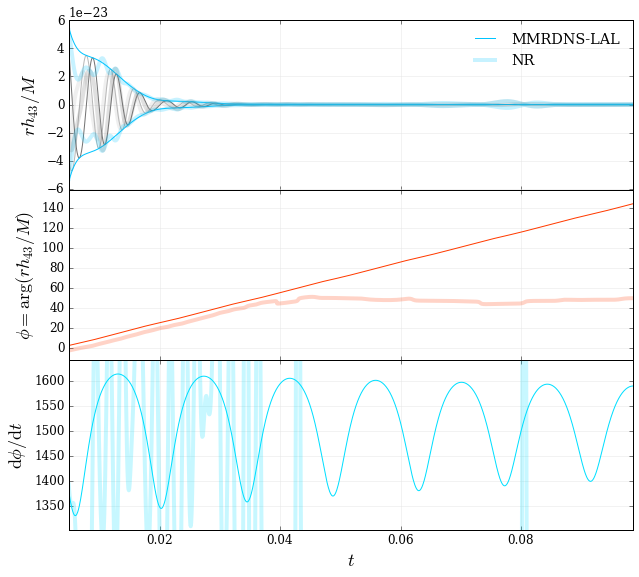

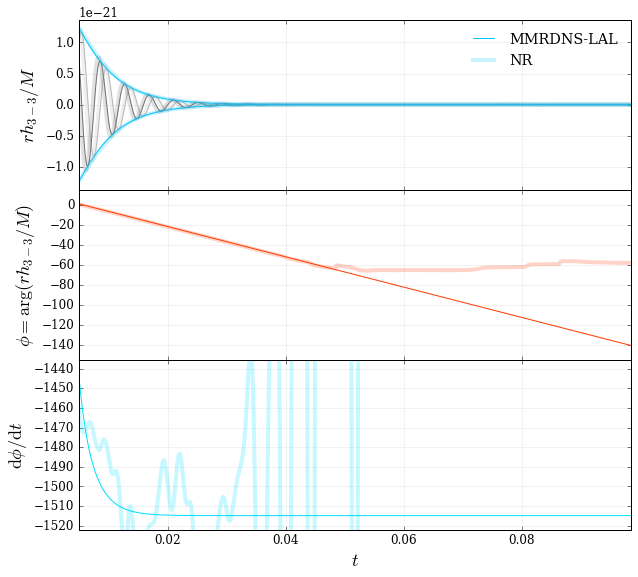

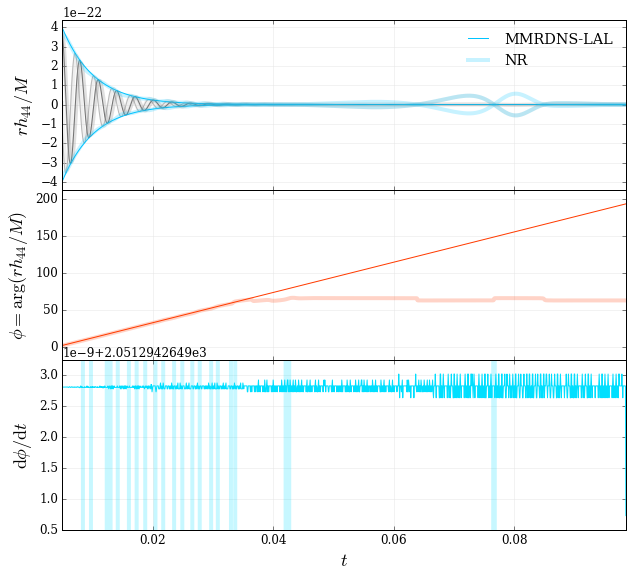

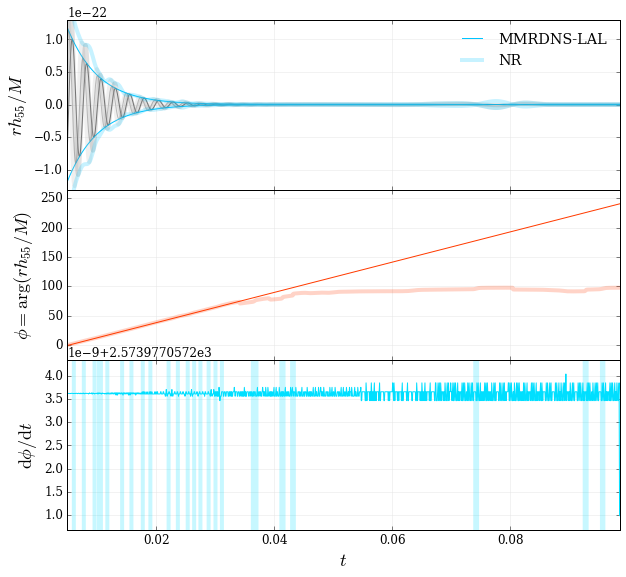

In [29]:
yrd_phys = yrd.copy()
# Convert NR waveform (class object data) to physical units
for k,h in enumerate(yrd_phys.hlm): 
    yrd_phys.hlm[k] = physh(h,M_Sol,D_Mpc)
    yrd_phys.__curate__()
# Align one multipole set to another and plot
yrd_phys.align(a,verbose=True,plot=True,kind='strain',plot_labels=('MMRDNS-LAL','NR'))
# a.align(yrd_phys,verbose=True,plot=True,kind='strain',plot_labels=('NR','MMRDNS-LAL'))

## Compare Spherical Representation to NR + Spheroidal by plotting

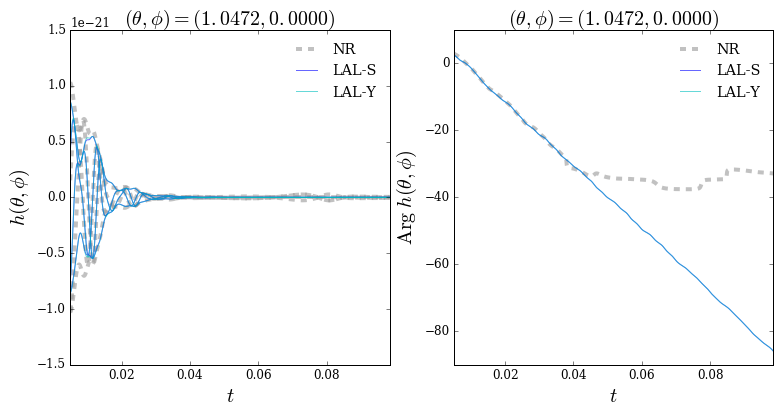

In [30]:
theta,phi = pi/3,0

hp,hc = lalsim.SimRingdownGenerateFullSphericalWaveform_time( 0,0, deltaT, len(t_code), Mf, xf, eta, theta, phi, D, None )
hlalY = hp.data.data + 1j*hc.data.data

hp,hc = lalsim.SimRingdownMMRDNS_time(0.0,deltaT,len(t_code),Mf,xf,eta,theta,phi,D,nonGRparams=None)
hlalS = hp.data.data + 1j*hc.data.data

hnr = yrd_phys.recompose( theta,phi,kind='strain',domain='time').y.conj()
hnr = yrd_phys.recompose( theta,phi,kind='strain',domain='time').wfarr
hnr = hnr[:,1]-1j*hnr[:,2]
hnr2 = yrd_phys.recompose( theta,phi,kind='strain',domain='time',select_lm=[(2,2),(2,-2),(3,3),(3,-3),(2,1),(2,-1)]).y.conj()


#
fig = figure( figsize = 6*array([2.1,1]) )

#
def plotc(c,color='k',alpha=1,label=None,linestyle='-',lw=2):
    #
    subplot(1,2,1)
    alpha = 0.6
    plot( t, c.real, color = color, alpha=alpha, label=label,linestyle=linestyle,linewidth=lw )
    plot( t, c.imag, color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    plot( t, abs(c), color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    plot( t,-abs(c), color = color, alpha=alpha,linestyle=linestyle,linewidth=lw )
    xlim( lim(t) )
    legend( frameon=False, loc='best' )
    xlabel(r'$t$'); ylabel(r'$h(\theta,\phi)$')
    title(r'$(\theta,\phi)=(%1.4f,%1.4f)$'%(theta,phi))
    #
    subplot(1,2,2)
    alpha = 0.6
    plot( t, unwrap(angle(c)), color = color, alpha=alpha, label=label,linestyle=linestyle,linewidth=lw )
    xlim( lim(t) )
    xlabel(r'$t$'); ylabel(r'$\mathrm{Arg}\;h(\theta,\phi)$')
    title(r'$(\theta,\phi)=(%1.4f,%1.4f)$'%(theta,phi))
    legend( frameon=False, loc='best' )
    
#
plotc( hnr, label='NR', color=0.6*ones(3), lw=4,linestyle='--' )
# plotc( hnr2, label='NR (subset)', color=0.1*ones(3), lw=1,linestyle='-' )
plotc( hlalS, label='LAL-S', color='b',lw=1 )
plotc( hlalY, label='LAL-Y', color='c',lw=1 )